# Running a single Schwarzschild model

By the end of the notebook, you will have run a Schwarzschild model. This will involve,
1. understanding the configuration file
2. executing commands to create and run a Schwarzschild model
3. plotting some output for this model

## Setup

You should be in the directory ```docs/tutorial_notebooks```. If this is the first time you have run these tutorial, this directory should have the following structure, 

```
tutorial_notebooks
  |- 
  | |- NGC6278_input
  |     |- mge.ecvs
  |     |- gauss_hermite_kins.ecvs
  |     |- bins.dat
  |     |- aperture.dat
  |
  |- NGC6278_config.yaml
  |- *.ipynb 
```

We have provided example input data files and a configution file for the galaxy NGC6278. The input data files are:

- ``mge.ecvs`` - the Multi Gaussian Expansion (MGE) describing the stellar surface density
- ``gauss_hermite_kins.ecvs`` - the kinematics extracted for this galaxy
- ``aperture.dat`` - information about the spatial apertures/bins using for kinematic extraction
- ``bins.dat`` - information about the spatial apertures/bins using for kinematic extraction

The MGE and kinematics files must be in the form of [Astropy ECSV files](https://docs.astropy.org/en/stable/api/astropy.io.ascii.Ecsv.html). This is a convenient and flexible file format, so we use it wherever possible for storing our input and output data.

We have provided test data for one galaxy. A very basic set of instructions for generating your own input data are as follows,

- fit and MGE to a photometric image e.g. using [mge](http://www-astro.physics.ox.ac.uk/~mxc/software/#mge)
- Voronoi bin your IFU datacube e.g. using [e.g. vorbin](http://www-astro.physics.ox.ac.uk/~mxc/software/#binning)
- extract kinematics from the binned datacube e.g. using [e.g. PPXF](http://www-astro.physics.ox.ac.uk/~mxc/software/#ppxf)
- make the apertures and binfile files. An example script which has created these files is the file ``generate_input_califa.py`` in [this directory](https://github.com/dynamics-of-stellar-systems/triaxschwarz/tree/sabine/schwpy/data_prepare)

In the future, we will provide more examples of test data, and more detailed instructions for preparing your own data.

To get started, let's import DYNAMITE and print the version and installation path,

In [1]:
import dynamite as dyn

print('DYNAMITE')
print('    version', dyn.__version__)
print('    installed at ', dyn.__path__)

DYNAMITE
    version 2.0.0
    installed at  ['/Users/maindl/.local/lib/python3.8/site-packages/dynamite-2.0.0-py3.8.egg/dynamite']


## Reading the configuration file

The configuration file controls all of the settings that you may wish to vary when running your Schwarschild models, e.g.

- specifing the components of the gravitational potential
- specifing the potential parameters, or parameter ranges, etc
- specify what type of kinematic data you are providing, e.g.
    - discrete vs continuous,
    - Gauss Hermite vs Histograms
- the location of the input and output files
- the number of models you want to run

This list of options is incomplete - for a more detailed description of the configuration file, see the documentation.

The configuration file for this tutorial is
```
NGC6278_config.yaml
```
Open this file in a text editor, alongside this notebook, to see how it is organised. The file is in ``yaml`` format. The basic structure of a yaml files are pairs of keys and values
```
key : value
```
which can be organised into hierarchical levels separated by tabs
```
main_key:
    sub_key1 : value1
    sub_key2 : value2
```
Comments begin with a ``#``. Values can be any type of variable e.g. integers, floats, strings, booleans etc.

To read in the congfiguration file we can use the following command, creating a configuration object which here we call ``c``,

In [4]:
fname = 'NGC6278_config.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)

[INFO] 11:53:38 - dynamite.config_reader.Configuration - Config file NGC6278_config.yaml read.
[INFO] 11:53:38 - dynamite.config_reader.Configuration - io_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - model_components...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - ... using 4 CPUs.
[INFO] 11:53:38 - dynamite.config_reader.Configuration - legacy_settings...
[INFO] 11:53:38 - dynamite.config_reader.Configuration - System assembled
[INFO] 11:53:38 - dynamite.config_reader.Confi

On making this object, some output is printed telling us whether any previous models have been found. Assuming that you're running this tutorial for the first time, then no models will be found and an empty table is created at ``AllModels.table``. This table holds holds information about all the models which have been run so far.

The configuration object ``c`` is structured in a similar way to the the configuration file itself. For example, the configuration file is split into two sections. The top section defines aspects the physical system we wish to model - e.g. the globular cluster, galaxy or galaxy cluster - while the second section contains all other settings we need for running a model - e.g. settings about the orbit integration and input/output options. The two sections are stored in the ``system`` and ``settings`` attributes of the configuration object, respectively,

In [5]:
print(type(c.system))
print(type(c.settings))

<class 'dynamite.physical_system.System'>
<class 'dynamite.config_reader.Settings'>


The physical system is comprised of components, which are stored in a list ``c.system.cmp_list``

In [6]:
print(f'cmp_list is a {type(c.system.cmp_list)}')
print(f'cmp_list has length {len(c.system.cmp_list)}')

cmp_list is a <class 'list'>
cmp_list has length 3


Let's print information about the components,

In [7]:
for i in range(3):
    
    print(f'Information about component {i}:')

    # extract component i from the component list
    component = c.system.cmp_list[i]

    # print the name
    print(f'   name =  {component.name}')

    # print a list of the names of the parameters of this component
    parameters = component.parameters
    parameter_names = [par0.name for par0 in parameters]
    string = '   has parameters : '
    for name in parameter_names:
        string += f'{name} , '
    print(string)

    # print the type of this component
    print(f'   type =  {type(component)}')

    # does it contribute to the potential?
    print(f'   contributes to the potential? -  {component.contributes_to_potential}')

Information about component 0:
   name =  bh
   has parameters : m-bh , a-bh , 
   type =  <class 'dynamite.physical_system.Plummer'>
   contributes to the potential? -  True
Information about component 1:
   name =  dh
   has parameters : c-dh , f-dh , 
   type =  <class 'dynamite.physical_system.NFW'>
   contributes to the potential? -  True
Information about component 2:
   name =  stars
   has parameters : q-stars , p-stars , u-stars , 
   type =  <class 'dynamite.physical_system.TriaxialVisibleComponent'>
   contributes to the potential? -  True


Each component has a name, some parameters, and a type. **Currently, dynamite only supports this exact combination of compoenent types**, i.e.

- one ``Plummer``  component representing the black hole
- one ``NFW`` component representing the dark halo (as of v1.0.0, DYNAMITE additionally supports ``Hernquist``, ``TriaxialCoredLogPotential``, and ``GeneralisedNFW`` dark halos, see documentation)
- one ``TriaxialVisibleComponent`` representing the stellar body of the galaxy

In the future, we want to support other components, and more flexible combinations of components.

For the stars - i.e. component 2 - we must provide some input data files. The location of these files is specified in the configuration file, at
```
settings -> io_settings -> input_directory
```
which takes the value,

In [8]:
c.settings.io_settings['input_directory']

'NGC6278_input/dynamite_input/'

The names of the following files are also specified in the configuration file, in the locations
```
system_components -> stars -> mge_pot
system_components -> stars -> mge_lum
system_components -> stars -> kinematics -> <kinematics name> --> datafile
system_components -> stars -> kinematics -> <kinematics name> --> aperturefile
system_components -> stars -> kinematics -> <kinematics name> --> binfile
```
which take values of the appropriate filenames. You are free to give these files whatever name you like, as long as it is specified in the configuration file.

Let's have a look at the MGE,

In [12]:
c.system.cmp_list[2].mge_pot, c.system.cmp_list[2].mge_lum

(MGE({'name': None, 'datafile': 'mge.ecsv', 'input_directory': 'NGC6278_input/dynamite_input/', 'data': <Table length=6>
    I      sigma      q    PA_twist
 float64  float64  float64 float64 
 -------- -------- ------- --------
 26819.14  0.49416 0.89541      0.0
  2456.39  2.04299 0.79093      0.0
    456.8  2.44313  0.9999      0.0
   645.49   6.5305 0.55097      0.0
    14.73 17.41488  0.9999      0.0
   123.85 21.84711 0.55097      0.0, 'logger': <Logger dynamite.data.Data (DEBUG)>}),
 MGE({'name': None, 'datafile': 'mge.ecsv', 'input_directory': 'NGC6278_input/dynamite_input/', 'data': <Table length=6>
    I      sigma      q    PA_twist
 float64  float64  float64 float64 
 -------- -------- ------- --------
 26819.14  0.49416 0.89541      0.0
  2456.39  2.04299 0.79093      0.0
    456.8  2.44313  0.9999      0.0
   645.49   6.5305 0.55097      0.0
    14.73 17.41488  0.9999      0.0
   123.85 21.84711 0.55097      0.0, 'logger': <Logger dynamite.data.Data (DEBUG)>}))

The kinematics are stored here,

In [13]:
type(c.system.cmp_list[2].kinematic_data)

list

Note that this object has type ``list``. This is because a single component can have multiple different sets of kinematics. In this example, the first (and only) entry in the list is

In [14]:
type(c.system.cmp_list[2].kinematic_data[0])

dynamite.kinematics.GaussHermite

We see that this kinematics object has type ``GaussHermite``. This has also been specified in the configuration file, under
```
system_components -> stars -> kinematics --> kinset1 --> type
```
In addition to ``GaussHermite``, DYNAMITE also supports ``BayesLOSVD`` kinematics (see documentation).

The kinemtic data itself can be accessed as follows,

In [15]:
c.system.cmp_list[2].kinematic_data[0].data

vbin_id,v,dv,sigma,dsigma,h3,dh3,h4,dh4
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,-44.7518,2.0988,211.7829,1.9654,0.0,0.005,0.0,0.005
2,-69.2798,2.3608,188.883,2.1766,0.0,0.005,0.0,0.005
3,-70.8007,3.9338,177.095,3.7142,0.0,0.005,0.0,0.005
4,-47.9191,3.4617,184.1865,3.0684,0.0,0.005,0.0,0.005
5,-30.5932,2.386,208.2472,2.2207,0.0,0.005,0.0,0.005
6,-76.5504,5.5494,162.3144,4.572,0.0,0.005,0.0,0.005
7,-49.8285,4.4211,174.0705,3.6461,0.0,0.005,0.0,0.005
8,-35.7514,3.5335,180.28,3.3672,0.0,0.005,0.0,0.005
9,-75.4144,3.5041,139.9438,3.9235,0.0,0.005,0.0,0.005


## Creating a Schwarzschild model

Our next step will be to create a model i.e. a ``dyn.model.Model`` object. To help understand what the Model object is, let's read the internal documentation (i.e. the docstring) for the class:

```
class Model(object):
    """A DYNAMITE model.

    The model can be run by running the methods (i) get_orblib, (ii) get_weights
    and (iii) (in the future) do_orbit_colouring. Running each of these methods
    will return the appropriate object, e.g. model.get_orblib() --> returns an
    OrbitLibrary object model.get_weights(...) --> returns a WeightSolver object

    Parameters
    ----------
    config : a ``dyn.config_reader.Configuration`` object
    parset : row of an Astropy Table
        contains the values of the potential parameters for this model
    directory : str
        The model directory name (without path). If None or not specified,
        the all_models_file will be searched for the directory name. If the
        all_models file does not exist, the model directory will be set to
        ``orblib_000_000/ml{ml}``.

    Returns
    -------
    Nothing returned. Attributes holding outputs are are added to the
    object when methods are run.

    """
    def __init__(self, config=None, parset=None, directory=None):
```
Looking at the init signature for this class, we see that a ``Model`` requires 3 input arguments. We've already met the first, the configuration object ``c``.

The remaining input parameter we need to provide is ``parset``. This is a particular set of values for each of the parameters of the model. In the configuration file, every parameter has a been given a ``value``. We can extract a parameter set specified by these values as follows,

In [17]:
parset = c.parspace.get_parset()
print(parset)

  m-bh    a-bh c-dh f-dh q-stars p-stars u-stars  ml
-------- ----- ---- ---- ------- ------- ------- ---
100000.0 0.001  8.0 10.0    0.54    0.99  0.9999 5.0


Note that, compared to values specified in the configuration file, parameters which have been specified as logarithmic, i.e. those configured as 
```
parameters -> XXX -> logarithmic : True
```
have been exponentiated in this table. More details can be found in the tutorial/documenation XXXXX.

With the first 2 input arguments at hand, we can now create our model object,

In [18]:
model = dyn.model.Model(config=c, parset=parset)

[INFO] 12:22:01 - dynamite.model.Model - The all_models file NGC6278_output/all_models.ecsv does not exist - model directory set to NGC6278_output/models/orblib_000_000/ml5.00/.


As this is our first model and we did not specify an explicit model directory, a standard directory name has been assigned to the model. Note that this path has not been created in the file system so far.

Having created the model object, we can now run it. First, lets create directories for the output,

In [19]:
model.setup_directories()

This should have create a directory, where the name has been specified in the config file, 

In [20]:
c.settings.io_settings['output_directory']

'NGC6278_output/'

inside of which you should find 
```
NGC6278_output/models/
```
inside of which a unique directory for *this particular* model has been created, called

In [21]:
model.get_model_directory()

[INFO] 12:26:43 - dynamite.model.Model - The all_models file NGC6278_output/all_models.ecsv does not exist - model directory set to NGC6278_output/models/orblib_000_000/ml5.00/.


'NGC6278_output/models/orblib_000_000/ml5.00/'

The directory name is constructed from the standard name for new, directly created models and their ``ml`` value.

The next step is to calculate the orbit library. This step will take a few minutes,

In [22]:
model.get_orblib()

[INFO] 12:28:09 - dynamite.orblib.LegacyOrbitLibrary - Calculating initial conditions
[INFO] 12:28:55 - dynamite.orblib.LegacyOrbitLibrary - Integrating orbit library tube orbits
[INFO] 12:29:03 - dynamite.orblib.LegacyOrbitLibrary - Integrating orbit library box orbits


Having calculated an orbit library, we now need to find out which orbits are useful for reproducing the observations. This is an Non-Negative Least Squares (NNLS) optimization problem, which can be solved as follows

In [23]:
model.get_weights()

[INFO] 12:29:32 - dynamite.weight_solvers.LegacyWeightSolver - Using WeightSolver: LegacyWeightSolver
[INFO] 12:29:32 - dynamite.weight_solvers.LegacyWeightSolver - Fitting orbit library to the kinematic data: ml5.00


Congratulations! You have run your first Schwarzschild model using DYNAMITE. The chi-squared of this model is,

In [24]:
model.chi2

32879.18862513153

Is that good? I don't know! To find out, we'll have to run more models and compare their chi-squared values. For information about this, see the tutorial running_a_grid_of_models.

## Plot the Models

Now let's look at some output for the model that we have just run

[INFO] 12:30:37 - dynamite.plotter.Plotter - Plotting kinematic maps for kin_set no 0: califa
[INFO] 12:30:37 - dynamite.weight_solvers.LegacyWeightSolver - Using WeightSolver: LegacyWeightSolver
[INFO] 12:30:37 - dynamite.weight_solvers.LegacyWeightSolver - NNLS solution read from existing output


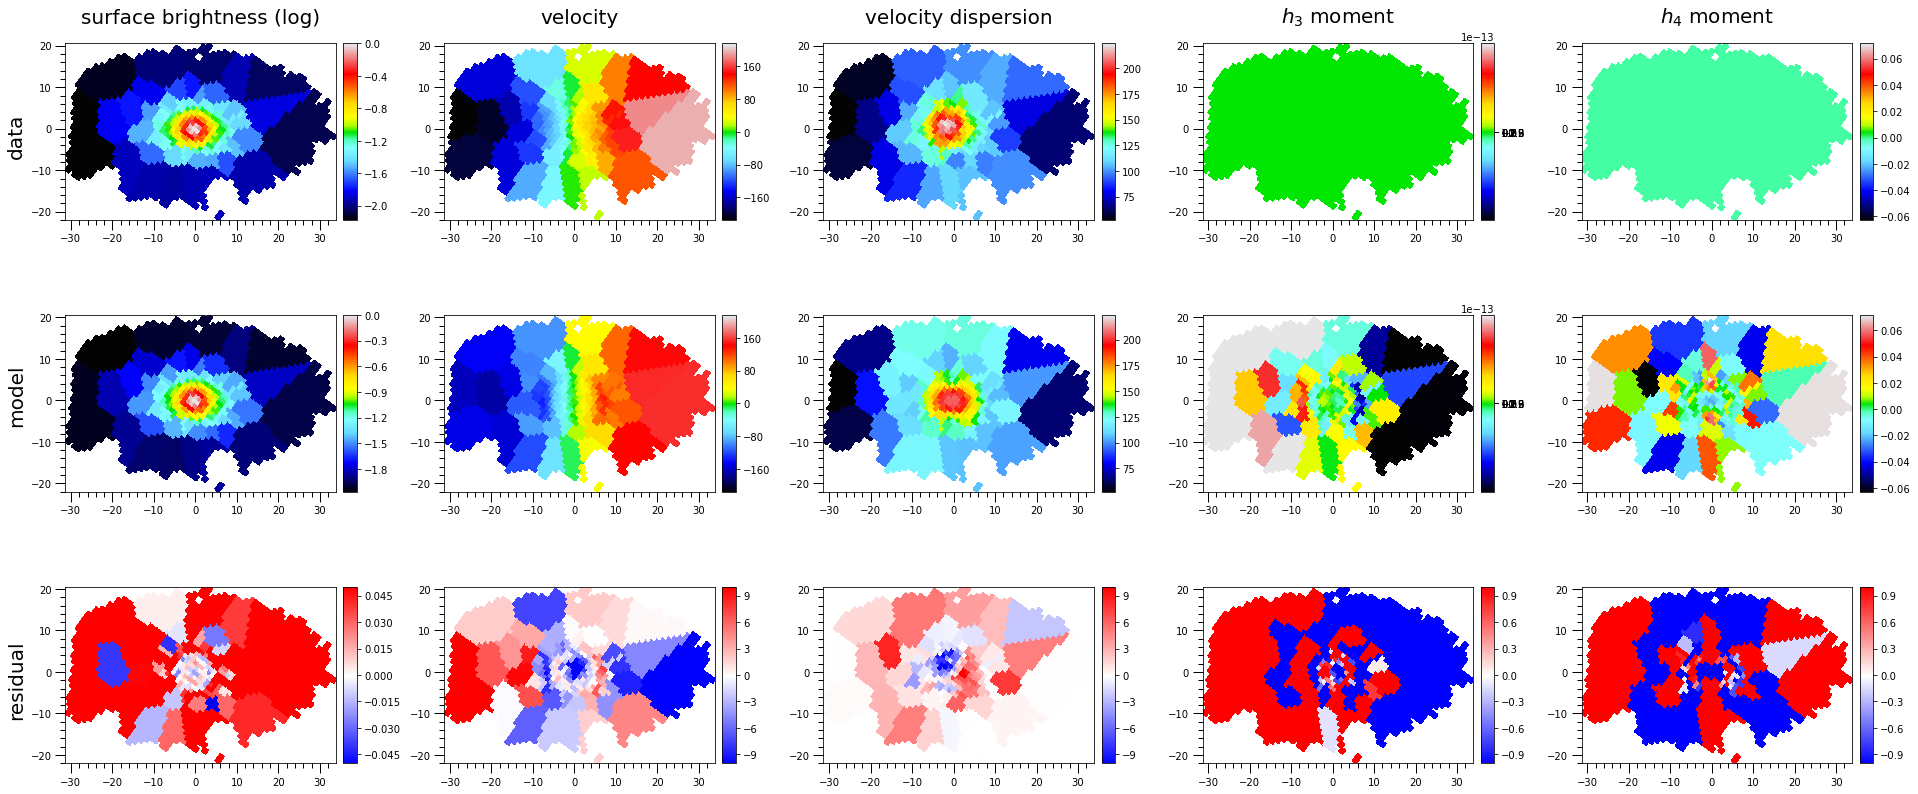

In [25]:
plotter = dyn.plotter.Plotter(config=c)

figure = plotter.plot_kinematic_maps(model)

The top row shows the data, the middle row shows the model, and the bottom row shows the residuals. The columns, from left to right, are the stellar surface density, $V$, $\sigma$, $h_3$ and $h_4$. We can see the following features in the fit,

- the model and data surface densities are very similar
- the sense of rotation of the $v$ map is reproduced well, though the amplitude is lower than observed
- the $\sigma$, $h_3$ and $h_4$ maps are less well reproduced

Whilst the fit is certainly not perfect, it's reassuring to see that some features are reproduced well. To imporve the fit, we will have to explre parameter space more fully. See the tutorial on "running a grid of models" for more details.

## Exercise

Change one of the potential parameters, then run another Schwarzschild model. You could do this by creating a new configuration file, or manually changing one of the parameters in this notebook. For example, to change the parameter ``ml`` - which is the mass-to-light ratio of the stars - to six, then you can uncomment the next line,

In [26]:
# parset['f'] = 6.

Change any parameter you would like, then re-run a model and save the output plots.